<a href="https://www.kaggle.com/code/aisuko/convolutional-neural-network?scriptVersionId=137107215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Convolutional nerual network

In the [Training a simple dense neural network](https://www.kaggle.com/code/aisuko/training-a-simple-dense-neural-network) using class definition, but those networks were generic, and not specialized for computer vision tasks. This time we will trying to define `Convolutional Neural Networks(CNNs)`, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to fing a certain object in the picture, we are scanning the image looking for some specific `patterns` and their combinations. For example, when looking for a catm,, we first may look for horizontal lines, which can form whiskers, and then certain combinations of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image.

To extract patterns, we will use the notion of `convolutional filters`.

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
# check the paltform, Apple Silicon or Linux
import os, platform

torch_device="cpu"

if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    torch_device = 'cuda'
else:
    torch_device = 'mps' if platform.system() == 'Darwin' else 'cpu'

In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
torch_device

'cuda'

In [5]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

In [6]:
data_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 97326661.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15983070.83it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24332795.24it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17938351.01it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Peek digit dataset 

In [7]:
print('Digit to be predicted:',data_train[0][1])

Digit to be predicted: 5


In [8]:
train_loader = DataLoader(data_train, batch_size=128)
test_loader = DataLoader(data_test, batch_size=128)

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and weighted average of the neighboring pixels. Here are the examples of applying two different convolutional filters over our MNIST handwritten digits:

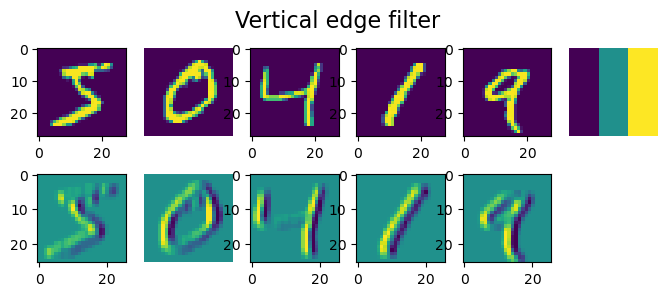

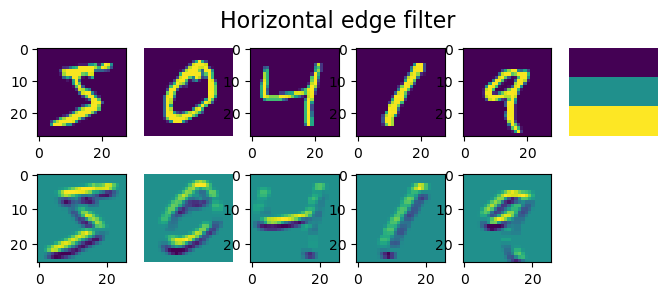

In [9]:
def plot_convolution(t, title=''):
    with torch.no_grad():
        # nn.Con2d is used to perform the convolution
        # * kernel_size is the size of the filter, filter is a 3x3 matrix
        # * out_channels is the number of filters to use, this corresponds to the number of output channels
        # * in_channels is the number of channels in the input image, this corresponds to the number of input channels
        # * the channels are the colors, so for a color image, the number of channels is 3 (red, green, blue)
        # * for a grayscale image, the number of channels is 1
        c = nn.Conv2d(kernel_size=(3,3), out_channels=1, in_channels=1)
        c.weight.copy_(t) # copy the filter to the convolution layer
        fig, ax=plt.subplots(2,6,figsize=(8,3)) # create a figure with 2 rows and 6 columns, each plot is 8x3
        fig.suptitle(title, fontsize=16) # set the title of the figure
        for i in range(5):
            im = data_train[i][0] # get the image
            ax[0][i].imshow(im[0]) # plot the image
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0]) # plot the convolution
            ax[0][1].axis('off') # turn off the axis
            ax[1][1].axis('off') # turn off the axis
        ax[0,5].imshow(t) # plot the filter
        ax[0,5].axis('off') # turn off the axis
        ax[1,5].axis('off') # turn off the axis
        plt.show() # show the plot

plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]), 'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]), 'Horizontal edge filter')

First fileter is called a `vertical edge filter`, and it is defined by the following matrix:

$$
\left(\begin{matrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{matrix}
\right)
$$

When this filter goes over realatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An oposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, **multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier**. However, in `deep learning` we construct networks that `learn` best convolutional filters to sovle classfication problem.

To do that, we introduce `convolutional layers`.

## Covolutional layers

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:

* `in_channels` - number of channels in the input image. For example, MNIST images are grayscale, so we have only one channel. If we were using color images, we would have 3 channels - red, green and blue.
* `out_channels` - number of channels produced by the convolution. This is equal to the number of filters we want to use.
* `kernel_size` - size of the convolutional filter(sliding window). For example, if we have `kernel_size=3`, then each convolutional filter will be 3x3. Usually 3x3 or 5x5 filters are used.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flattern 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `ReLU` activation function in between layers.

In [10]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(kernel_size=(5,5), out_channels=9, in_channels=1) # create a convolution layer
        self.flatten = nn.Flatten() # nn.Flattern is used to flatten the output of the convolution layer to a vector
        self.fc = nn.Linear((9*24*24), 10) # create a fully connected layer
    def forward(self, x):
        x = nn.functional.relu(self.conv(x)) # nn.funtional is used to apply the relu function
        x = self.flatten(x) # flatten the output of the convolution layer
        x = nn.functional.log_softmax(self.fc(x), dim=1) # apply the log_softmax function to the output of the fully connected layer, more https://www.kaggle.com/code/aisuko/building-the-model-layers?scriptVersionId=136624674&cellId=28
        return x

net=OneConv().to(torch_device)
summary(net, input_size=(1,1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

Epoch  0, Train acc=0.942, Val acc=0.969, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.978, Val acc=0.974, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.983, Val acc=0.972, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.976, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.988, Val acc=0.977, Train loss=0.000, Val loss=0.001


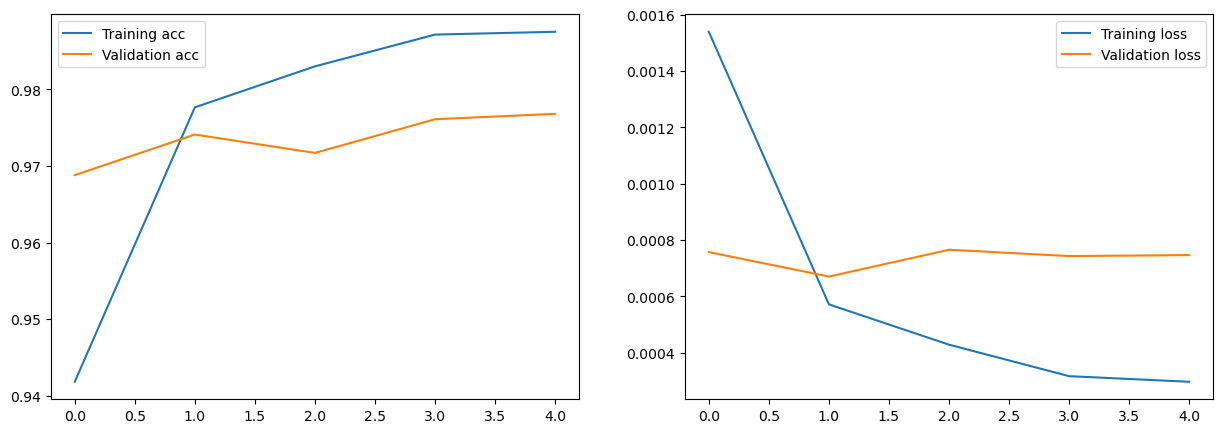

In [11]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    net.train() # put the network into training mode make sure the parameters are trainable
    total_loss,acc,count =0,0,0
    for features, labels in dataloader:
        features,labels = features.to(torch_device), labels.to(torch_device)
        optimizer.zero_grad() # reset the gradients to zero before each batch to avoid accumulation
        out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
        loss=loss_fn(out,labels) # compute the loss
        loss.backward() # compute the gradients of the loss with respect to all the parameters of the network
        optimizer.step() # update the parameters of the network using the gradients to minimize the loss
        total_loss+=loss # accumulate the loss for inspection
        _,preds=torch.max(out,dim=1) # compute the predictions to obtain the accuracy
        acc+=(preds==labels).sum() # accumulate the correct predictions
        count+=len(labels) # accumulate the total number of examples
    return total_loss.item()/count, acc.item()/count # return the loss and accuracy

def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval() # put the network into evaluation mode to deactivate the dropout layers
    count,acc,loss =0,0,0
    with torch.no_grad(): # deactivate autograd to save memory and speed up computations
        for features, labels in dataloader:
            features,labels = features.to(torch_device), labels.to(torch_device)
            out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
            loss += loss_fn(out,labels) # compute the loss
            preds=torch.max(out,dim=1)[1] # compute the predictions to obtain the accuracy
            acc+=(preds==labels).sum() # accumulate the correct predictions
            count+=len(labels) # accumulate the total number of examples
    return loss.item()/count, acc.item()/count # return the loss and accuracy

def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer,lr=lr, loss_fn=loss_fn)
        vl,va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5)) # figure is used to create a new figure
    plt.subplot(121) # subplot is used to create a new subplot on a grid
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend() # legend is used to add a legend to the plot
    plt.subplot(122) # plot the loss
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

As you can see, we are able to achieve higher accuracy, and much faster, compared to the fully-connected networks. We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

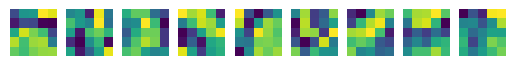

In [12]:
fig, ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

You can see that some of those filters look like they can recognize some oblique strokes, while others loook pretty random.

## Multi-layered CNNs and pooling layers

First converlutional layers looks for primitive patterns, such as horizontal or vertical lines, but we can apply further convolutional layers on top of them to look for higher-level patterns, such as primitive shapes. Then more convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classsify.

When doing so, we may also apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within sliding 3x3 window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the `pooling layers`:

* `Average Pooling` takes a sliding window (for example, 2x2 pixels) and computes an average of valyes within the window
* `Max Pooling` replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced  - there are more possible interesting combinations that we need to be looking for.

<figure><img src="https://hostux.social/system/media_attachments/files/110/729/082/002/900/524/original/1c7f7d5fc1cc2373.png" alt="" ><figcaption><p>Source from Microsoft learning</p></figcaption></figure>

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called `pyramid architecture`.

In [13]:
class MultiLayerCNN(nn.Module):
    def __init__(self) -> None:
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,10,5) # 1 input channel, 10 output channels, 5x5 filter
        self.pool = nn.MaxPool2d(2,2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(10,20,5) # 10 input channels, 20 output channels, 5x5 filter
        self.fc = nn.Linear(20*4*4,10) # 320 input features, 10 output features
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x))) # apply the first convolution, relu and pooling
        x = self.pool(nn.functional.relu(self.conv2(x))) # apply the second convolution, relu and pooling
        x = x.view(-1, 320) # view is used to reshape the tensor, -1 means the size is inferred from the other dimensions, 320 is the number of input features for the fully connected layer
        x = nn.functional.log_softmax(self.fc(x), dim=1) # apply the log_softmax function to the output of the fully connected layer, more https://www.kaggle.com/code/aisuko/building-the-model-layers?scriptVersionId=136624674&cellId=28
        return x

net = MultiLayerCNN().to(torch_device)
summary(net, input_size=(1,1,28,28)) # summary is used to print a summary of the network

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

Here are few things about this definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function. Since flattening layer does not have trainable weights, it is not essential that we create a separate layer instance within our class.
* We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and this one instance can be effectively resued.
* The number of trainable parameters (~8.5k) is dramatically smaller than in previous cases. This happens becuasee convolutional layers in general have few parameters, and dimentionality of the image before applying final dense layer is significantly reduced. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [14]:
hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.949, Val acc=0.982, Train loss=0.001, Val loss=0.000
Epoch  1, Train acc=0.980, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.985, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.986, Val acc=0.982, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.987, Val acc=0.986, Train loss=0.000, Val loss=0.000


What you should probably observe is that we are able to achieve higher accuracy than with just one layer, and much faster -  just with 1 or 2 epochs. It means that sophisticated network architecture needs much fewer data to figure out what is going on, and to extract generic patterns from our images.

## Playing with real images from the CIFAR-10 dataset

While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore more advanced dataset of pictures of different object, called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). It contains 60k 32x32 images, divided into 10 classes.

In [15]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(trainset, batch_size=14, shuffle=True) # shuffle is used to shuffle the data before each epoch in order to avoid overfitting
test_loader = DataLoader(testset, batch_size=14, shuffle=False)

classses = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # the classes is used to map the labels to the names of the classes

100%|██████████| 170498071/170498071 [00:02<00:00, 78233103.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


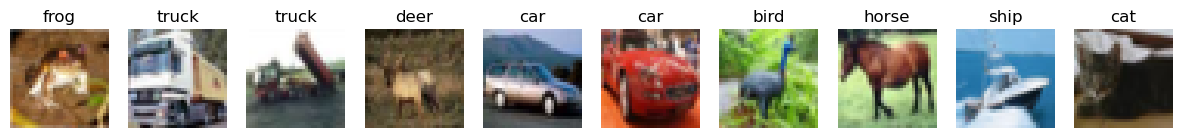

In [16]:
def display_dataset(dataset, n=10, classes=None):
    fig, ax=plt.subplots(1,n,figsize=(15,3))
    mn = min(dataset[i][0].min() for i in range(n))
    mx = max(dataset[i][0].max() for i in range(n))

    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn), (1,2,0))) # transpose is used to change the order of the dimensions in order to plot the image
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

display_dataset(trainset, classes=classses)

The architecture for CIFAR-10 is called LeNet, and has been proposed by Yann LeCun. It follows the same principles as we have outlined above, the main difference being 3 inpput color channels instead of 1.

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss function to optimize the model.

In [17]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) # 3 input channel, 6 output channels, 5x5 filter
        self.pool = nn.MaxPool2d(2,2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6,16,5) # 6 input channels, 16 output channels, 5x5 filter
        self.conv3 = nn.Conv2d(16,120,5) # 16 input channels, 120 output channels, 5x5 filter
        self.flat = nn.Flatten() # flatten the output of the convolution layer to a vector
        self.fc1 = nn.Linear(120,64) # 120 input features, 64 output features
        self.fc2 = nn.Linear(64,10) # 64 input features, 10 output features
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x))) # apply the first convolution, relu and pooling
        x = self.pool(nn.functional.relu(self.conv2(x))) # apply the second convolution, relu and pooling
        x = nn.functional.relu(self.conv3(x)) # apply the third convolution and relu
        x = self.flat(x) # flatten the output of the convolution layer
        x = nn.functional.relu(self.fc1(x)) # apply the first fully connected layer and relu
        x = self.fc2(x) # apply the second fully connected layer
        return x

net = LeNet().to(torch_device)
summary(net, input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Training this network properly will take significant amount of time, aand should preferably be done on GPU-enable compute.

In [18]:
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # use SGD optimizer with momentum
hist = train(net, train_loader, test_loader, epochs=5, optimizer=opt, loss_fn=nn.CrossEntropyLoss()) # use CrossEntropyLoss as loss function

Epoch  0, Train acc=0.382, Val acc=0.472, Train loss=0.119, Val loss=0.103
Epoch  1, Train acc=0.485, Val acc=0.506, Train loss=0.102, Val loss=0.099
Epoch  2, Train acc=0.519, Val acc=0.521, Train loss=0.097, Val loss=0.097
Epoch  3, Train acc=0.541, Val acc=0.525, Train loss=0.094, Val loss=0.097
Epoch  4, Train acc=0.553, Val acc=0.544, Train loss=0.092, Val loss=0.097


The accuracy that we have been able to achieve with 3 epochs of training does not see, great. However, remember that blind guessing would only give us 10% accuracy, and that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy in such a short training time seems like a good accomplishment.

Real-life architectures that power image classification, object detection, and even image generation networks are all based on CNNs, just with more layers and some additional tricks.

## Questions for review

#### If the size of an input image is 3x200x200, what would be the size of the tensor after applying a 5x5 convolutional layer with 16 filters?

To calcualte the size of the tensor after applying a 5x5 convolutional layer with 16 filters to an input image of size 3x200x200, we can use the formula:

$$Output size = (Input size - Filter size + 2 * Padding)/Stride +1$$

Given that the input image size is 3x200x200 and the filter size is 5x5, we can calcualte the output size as follows:
* Input size: 3x200x200
* Filter size: 5x5
* Padding: 0 (assuming no padding)
* Stride: 1 (assuming stride of 1)

For the first dimension (number of channels), the output size will be the same as the number of filters, which is 16.

For the second and third dimensions (height and width), we can use the formula:

$$Output size = (200 - 5 + 2 * 0)/1 +1 = 196$$

Therefore, the size of the tensor after applying a 5x5 convolutional layer with 16 filters to an input image of size 3x200x200 would be 16x196x196.